In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
  th {font-size: 15px}
  td {font-size: 15px}
</style>

# Outlier Filtering Paradox

Your product manager Tommy got an idea: what if Zalando's website background uses an image of a duck? 

After weeks of persuation, his manager yielded. Tommy went ahead and set up a standard experiment. Randomizated sampling works as expected. Two weeks later, the experiment finished. Now, join me to take a look at the duck's conversion rate!

## Experiment data

Let's first take a look at the orders in the control group, who saw a background image of Zalando models.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Make a util function for plots
def plot(df, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = np.arange(df.size)
    plt.plot(x, df)
    plt.xlabel("Rank of User")
    plt.ylabel("Number of Orders")
    plt.title(title)
    plt.subplot(122)
    x = np.arange(df.size)
    plt.plot(x, df)
    plt.xlabel("Rank of User")
    plt.ylabel("Number of Orders")
    plt.xlim(df.size*0.88, df.size*1.01)
    plt.title(title + " (Zoom In)")
    plt.show()

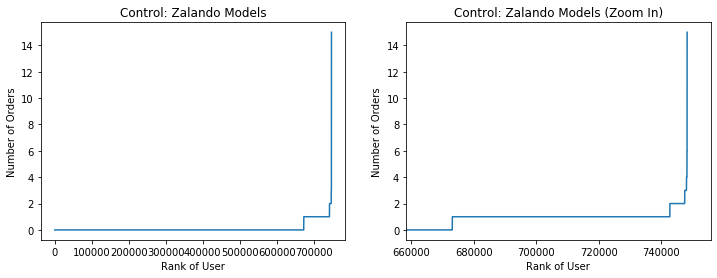

In [3]:
c = pd.read_csv("control_orders.csv", squeeze=True)
plot(c, "Control: Zalando Models")

We observed that number of orders is highly zero-inflated. The majority of users didn't make any order. A small proportion of users made multiple orders during the experiment period. This observation is well aligned with what we know about order data from historical experiments. Perfectly expected data. No surprise here.

Let's now fetch the data for treatment group who saw the image of a duck.

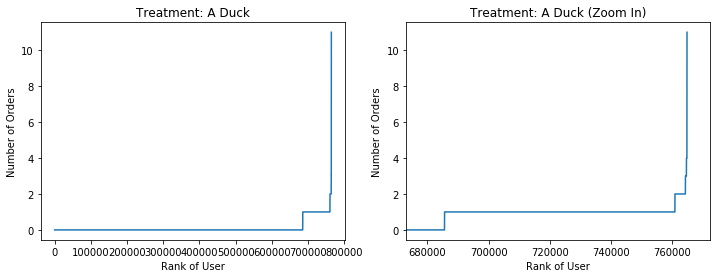

In [4]:
t = pd.read_csv("treatment_orders.csv", squeeze=True)
plot(t, "Treatment: A Duck")

Also zero-inflated. Also expected behavior. 

Keeping in mind that conversion rate is defined as number of orders per user, let's check out the difference of treatment and control then!

In [5]:
def output_uplift(c, t):
    c_cr, t_cr = c.mean(), t.mean()
    print("Uplift of conversion rate: {:+.2f}.".format((t_cr - c_cr) * 100))

In [6]:
output_uplift(c, t)

Uplift of conversion rate: +0.05.


From what we learned so far, a duck image helps Zalando to convert more!

## Outlier filtering

Right before the duck image is released to the whole population, Tommy's manager invited an Octopus member to double check the analysis. The Octopus member claimed that we need to do outlier filtering in the analysis. 

"You see, these extremely large number of orders may come from administrative accounts or blindly loyal customers. A different background image won't affect their purchases, so we should filter them out." The Octopus member insisted.

Tommy then took the advice and filterd out users who are above 99.9% quantile.

In [7]:
t999 = t.quantile(.999)
c999 = c.quantile(.999)

In [8]:
t_normal = t[t <= t999]
c_normal = c[c <= c999]
output_uplift(c_normal, t_normal)

Uplift of conversion rate: -0.05.


The treatment effect went from +0.05 to -0.05!  
The result changes direction after outlier filtering.

For this to happen, there must be larger numbers of orders from the outlier users in the treatment group. That's why removing them causes the control group start to perform better. With this hypothesis, let's compare the number of orders in the outlier users.

In [9]:
t_outliers = t[t > t999]
c_outliers = c[c > c999]
output_uplift(c_outliers, t_outliers)

Uplift of conversion rate: -136.53.


## What's going on?!
Heck!? Emm... let's summarize what we got:

| Conversion Rate          | Overall | Normal Users | Outlier Users |
| ---------------          | --------| --------     |  --------     |
| Treatment Effect Uplift  |   +0.05 |        -0.05 |       -136.53 |


So we divided the samples into two subgroups: normal users who are below 99.9% quantile and outlier users who are above 99.9% quantile. Control group shows higher conversion rate in both subgroups; however, the treatment group shows overall higher conversion rate! 

It's worth pointing out that this is not an example of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox), which occurs usually when the ratio of sample size in each subgroup are highly different. It's not the case here because we take the same quantile for control and treatment. So the ratio of sample size with and without outlier filtering should be very similar. 

Therefore, in our case of quantiles, we expect that the first number should be between other two!  

----
#### We can prove it mathmatically too

Let $\mu_c$ be the mean of control,   
let $\mu_c^n$ be the mean of normal users in control,    
and $\mu_c^o$ be the mean of outlier users in control.   
The same notation $\mu_t$, $\mu_t^n$ and $\mu_t^o$ apply for treatment.

Further, we use $\Delta$ to denote overall uplift,   
$\Delta^{n}$ to denote the uplift for normal users and   
$\Delta^{o}$ to denote the uplift for outlier users.

Let $p \in (0,1)$ be the p-percentile used in outlier filtering, which is 99.9% for us, 

then:

$\displaystyle
\begin{aligned}
          \mu_c &= (1-p) \mu_c^{o} + p \mu_c^{n} \\
          \mu_t &= (1-p) \mu_t^{o} + p \mu_t^{n} 
\end{aligned}
$

by linearity:

$\displaystyle
\begin{aligned}
  \mu_t - \mu_c &= (1-p) (\mu_t^{o} - \mu_c^{o}) + p (\mu_t^{n} - \mu_c^{n}) \\
  \Delta &= (1-p) \Delta^{o} + p \Delta^{n}
\end{aligned}
$

----

Thus, the overall uplift $\Delta$ is a weighted average of $\Delta^{o}$ and $\Delta^{n}$. In other words, it must be between the uplift of outlier users and the uplift of normal users. What is going on?

## Quantile filtering on discrete values

The devil is the discrete nature of number of orders -- they can only be non-negative integers. Multiple users can have the number of order which is at 99.9% quantile. These users cross the threshold, making it impossible to locate the exact position of 99.9% quantile. Let's confirm it by looking at the actual quantile value used in data.

In [10]:
print("Actual quantile used for control: {:.4f}".format(c_normal.size / c.size))
print("Actual quantile used for treatment: {:.4f}".format(t_normal.size / t.size))

Actual quantile used for control: 0.9997
Actual quantile used for treatment: 0.9993


Indeed, there are differences between the intended quantile 0.999 and the actual ones used. The next question is: does this small difference really cause the paradox described above? 

Since number of orders is non-negative integer, adding a tiny random noise to the data won't influence the mean value, but the random noise can make the discrete integers into continous values, making it possible to identify the exact position of 99.9% quantile.

In [11]:
def add_jitter(c, t):
    # Add vectors of random noise in the range of -0.005 to 0.005
    c_jitter = np.random.random(len(c)) * 0.01 - 0.005
    t_jitter = np.random.random(len(t)) * 0.01 - 0.005
    return c + c_jitter, t + t_jitter

In [12]:
# Apply the same computation on the noisy data

print("Overall:")
cj, tj = add_jitter(c, t)
output_uplift(cj, tj)

print("Normal users:")
tj999 = tj.quantile(.999)
cj999 = cj.quantile(.999)
tj_normal = tj[tj <= tj999]
cj_normal = cj[cj <= cj999]
output_uplift(cj_normal, tj_normal)

print("Outlier users:")
tj_outliers = tj[tj > tj999]
cj_outliers = cj[cj > cj999]
output_uplift(cj_outliers, tj_outliers)

print("---")
print("Actual quantile used for noisy control: {:.4f}".format(cj_normal.size / cj.size))
print("Actual quantile used for noisy treatment: {:.4f}".format(tj_normal.size / tj.size))

Overall:
Uplift of conversion rate: +0.05.
Normal users:
Uplift of conversion rate: +0.10.
Outlier users:
Uplift of conversion rate: -49.44.
---
Actual quantile used for noisy control: 0.9990
Actual quantile used for noisy treatment: 0.9990


The result makes more sense on the noisy data! 

Putting it altogether we have the combined table for conversion rate results:
    
| Treatment effect uplift  | Overall | Normal users | Outlier users | Actual quantiles for outlier (c/t) |
| ---------------          | --------| --------     |  --------     | -------                |
| Original discrete data   |   +0.05 |        -0.05 |       -136.53 | 0.9997 / 0.9993        |
| Data with random jitter  |   +0.05 |        +0.10 |       -49.44  | 0.9990 / 0.9990        |

The paradoxical behavior in the original discrete data can now be fully explained by the actual quantiles used. In the original result, the two quantiles used in treatment and in control is different, thus there are less users filtered in the control group. This means that the effect of outlier mean has less influence on the overall mean in the control group, which breaks our belief that overall uplift is a weighted average. It becomes more clear if we take a look at the math.

-----
Let the difference of the two actual p-percentiles be $\Delta_p$, s.t. $p^{'} = p + \Delta_p$, then: 

$\displaystyle
\begin{aligned}
          \mu_c &= (1-p) \mu_c^{o} + p \mu_c^{n} \\
          \mu_t &= (1-p-\Delta_p) \mu_t^{o} + (p+\Delta_p) \mu_t^{n} 
\end{aligned}
$

Subtract $\mu_c$ from $\mu_t$:

$\displaystyle
\begin{aligned}
  \mu_t - \mu_c &= (1-p) (\mu_t^{o} - \mu_c^{o}) - \Delta_p \mu_t^o + p (\mu_t^{n} - \mu_c^{n}) + \Delta_p \mu_t^n \\
  \Delta &= (1-p) \Delta^{o} + p \Delta^{n} - \Delta_p \mu_t^o + \Delta_p \mu_t^n \\
  \Delta &= (1-p) \Delta^{o} + p \Delta^{n} + \Delta_p (\mu_t^n-\mu_t^o) 
\end{aligned}
$

-----

## How the paradox occur

As we can see from the last formula, the overall uplift $\Delta$ is _not_ a weighted average of $\Delta^{o}$ and $\Delta^{n}$ anymore. The additional term $ \Delta_p (\mu_t^n-\mu_t^o)$ breaks this property. Depends on **a)** how different $\mu_t^n$ is from $\mu_t^o$ and **b)** how large is $\Delta_p$, it could lead to the paradoxical behavior in this notebook.

Unfortunately, in the case of number of orders, both cases are very likely to be true.

* $\mu_t^n-\mu_t^o$: Since number of orders is highly zero-inflated, the difference for 99.9% quantile outliers from the others must be significantly large.
* $\Delta_p$: Due to the narraw range of choices (e.g. from 1 to 15 orders in this data), there can be quite many users have the value at the 99.9% quantile. Therefore, the difference of actual quantiles used in treatment and control can be noticeable.

This is how the paradox occur. It happens when applying quantile outlier filtering on discrete KPIs.   
**And this is how a seemingly small (and often covert!) numerical problem causes a large bias.** 

##  The Octopus way: same outlier threshold for both variants

Alternatively, one can do outlier filtering for the complete sample instead of per variant. 


That is to say, we use `all999 = c.append(t).quantile(.999)` as the threshold of outliers for both variants. In this way, we define the same kind of users as outliers for both variants. In fact, this is the approach used in Octopus currently. The advantage of this approach is that there is a consistent definition of what is an outlier; on the other hand, it will be bound to have different quantiles used for control and treatment.

For simplicity, I won't copy the code again for the same computation filtered by `all999`. One can easily reproduce this result.

| Treatment effect uplift| Overall | Normal users | Outlier users | Actual quantiles for outlier (c/t) |
| --------------- | --------| -------- |  -------- | -------|
| Original data (outlier threshold per variant) | +0.05 | -0.05 |-136.53 | 0.9997 / 0.9993 |
| Original data (outlier threshold complete sample) | +0.05 | +0.17 |-1.68 | 0.9989 / 0.9993 |
| Data with random jitter  |   +0.05 | +0.10 | -49.44  | 0.9990 / 0.9990 |


The result using the outlier threshold for complete sample is not paradoxical for the example data here. But as we learned from the section [How the paradox occur](#How-the-paradox-occur), it can happen for other data when the addtional term $\Delta_p (\mu_t^n-\mu_t^o)$ is big enough and in opposite direction of $\Delta^{o}$ and $\Delta^{n}$. 

Well, which number we should report to Tommy? The current Octopus system will give +0.17, but is there a better choice?

## Conclusion and next step

This article demonstrates an outlier filtering paradox in A/B testing. The cause of this paradox is proved to be using quantile outlier filtering on discrete KPIs. The paradoxical behavior suggests that the result after outlier filtering might be biased.

Most of the primary KPIs used in Zalando have  discrete nature in them. For example, conversion rate as number of orders per user, click-through rate as number of clicks per user, number of visits in the last 28 days, etc.

With the problem described in the notebook, it's likely that Octopus has produced many biased results on these discrete KPIs after outlier filtering. Unless we know what we are doing, I am now strongly inclined to say that **outlier filtering in A/B testing is very dangerous**. 

Even though the approach used in this notebook, adding random jitter to discrete data, solves the numerical problem, it doesn't have a logical semantics -- it's strange in that for users who have the KPI value at outlier threshold, some will be filtered out and some will be kept for analysis.

The next step is to think about **why we do outlier filtering**. We should consider whether its necessary to filter outliers at all. If we do, under what circumstances we should filter outliers? For example, outlier filtering is a way to deal with data that has a power law distribution without a well-defined mean. Does this situation apply in Zalando? Follow-up research is needed in this topic.